In [1]:
from scipy.io.wavfile import read
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt
import math
import librosa
import soundfile as sf
import json
import re 
import io
from librosa.core.spectrum import power_to_db
import scipy

def FP2FIX(Val, Prec):
    if np.isscalar(Val):
        return int(Val * ((1<<Prec) - 1))
    else:
        return (Val * ((1<<Prec) - 1)).astype(np.int32)
def FIX2FP(Val, Prec):
    if np.isscalar(Val):
        return float(Val) / float(1<<Prec)
    else:
        return Val.astype(np.float32) / float(1<<Prec)
def gap_mulsRN(x, y, N):
    if np.isscalar(x) and np.isscalar(y):
        return int(int(x) * int(y) + (1<<(N-1))) >> N
    else:
        return (x.astype(np.int32) * y.astype(np.int32) + (1<<(N-1))).astype(np.int32) >> N
def qsnr(orig, quant):
    """Calculate the QSNR between two tensors
    """
    qerr = orig - quant
    sum_err = np.sum(qerr * qerr)
    sum_orig = np.sum(orig * orig)
    if sum_err > 0:
        if sum_orig < sum_err:
            if sum_orig == 0:
                return -math.inf
            else:
                # Means error is larger than signal
                return -int(round(10 * math.log10(sum_err/sum_orig), 0))
        # Error portion of signal
        return int(round(10 * math.log10(sum_orig/sum_err), 0))
    # Means no error
    return math.inf

In [9]:
file_path = "samples/yes.wav"
data, samplerate = sf.read(file_path)
#data = np.clip(data*3, -1, 1)

with open("MfccConfig.json", "r") as f:
    config = json.load(f)

frame_size = config['frame_size']
frame_step = config['frame_step']
n_fft = config['n_fft']
n_mels = config['n_mels']
fmin = config['fmin']
fmax = config['fmax']
dtype = config.get('dtype', "int")
high_prec = config.get('use_high_prec', False) or dtype == "fix32_scal"
use_power = False
rad4 = round(math.log(n_fft//2, 4)) == math.log(n_fft//2, 4)
ndct = config.get('n_dct', False)

frame_idx = 20
frame = data[frame_idx*config['frame_step']:frame_idx*config['frame_step']+config['frame_size']]

In [10]:
config

{'n_fft': 512,
 'win_func': 'hanning',
 'frame_size': 400,
 'frame_step': 160,
 'sample_rate': 16000,
 'n_mels': 40,
 'n_dct': 40,
 'fmin': 20.0,
 'fmax': 4000.0,
 'dtype': 'float16',
 'use_librosa': True}

In [11]:
from librosa.filters import get_window
from librosa import util
librosa_fft_window = get_window("hann", frame_size, fftbins=True)
# Pad the window out to n_fft size
librosa_fft_window = util.pad_center(librosa_fft_window, n_fft)

stft = librosa.core.spectrum.stft(data, n_fft, frame_step, frame_size, center=False, pad_mode="constant")
spect = np.abs(stft) ** (1 if not use_power else 2)
mel_basis = librosa.filters.mel(samplerate, n_fft, n_mels, fmin, fmax)
mel_spect = np.dot(mel_basis, spect)
logmel = power_to_db(mel_spect, top_db=None)
mfcc = scipy.fftpack.dct(logmel, axis=0, type=2, norm=None)
with open("ground_truth.h", "w") as f:
    f.write(f"float Ground_Truth_{frame_size}_{n_fft} = {{\n")
    for elem in mfcc.T.flatten():
        f.write(f"{elem}, ")
    f.write("};\n")
mfcc

array([[-2.58125841e+03, -2.82931156e+03, -2.84083285e+03, ...,
        -2.80648765e+03, -2.84941802e+03, -2.90688134e+03],
       [-7.42654009e+01, -1.50694569e+01,  2.14191916e+01, ...,
        -2.25321745e+00, -3.55597362e+01, -1.85639080e+01],
       [ 3.37116962e+01,  6.46678093e+01,  1.10413046e+02, ...,
         9.28208380e+01,  8.22531848e+01,  6.17329813e+01],
       ...,
       [ 4.07039198e+00,  7.98904601e+00,  8.90213326e+00, ...,
        -1.46338874e+01, -3.96503683e+00,  1.30272553e+01],
       [ 1.03983748e+01,  7.80702608e-01, -6.67624914e+00, ...,
         9.67274701e+00,  2.94455473e+00,  5.50445468e+00],
       [-3.40372131e+00,  1.08643042e+01, -2.66690252e+00, ...,
        -1.35489864e+01,  9.08998249e-01, -4.47300300e+00]])

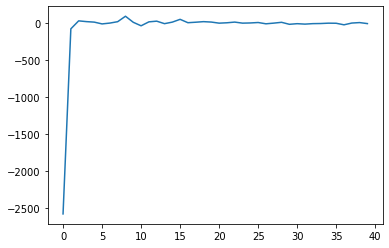

In [12]:
plt.plot(mfcc.T[0])

In [8]:
GAP_Shift 			= {"Matcher": re.compile(r"Shift\s=\s(?P<value_list>[-0-9]+)")					, "values": []}
GAP_out_preemph 	= {"Matcher": re.compile(r"out_preemph_c = \[\t*(?P<value_list>[^\)\]]+)]\)")	, "values": []}
GAP_out_window  	= {"Matcher": re.compile(r"out_window_c = \[\t*(?P<value_list>[^\)\]]+)]\)")	, "values": []}
if dtype == 'fix32_scal':
    GAP_out_fft 		= {"Matcher": re.compile(r"out_swapped_fft = \[\t*(?P<value_list>[^\)\]]+)]\)") , "values": []}
    GAP_out_fft_shift   = {"Matcher": re.compile(r"out_fft_shift = \[\t*(?P<value_list>[^\)\]]+)]\)"), "values": []}    
else:
    GAP_out_fft 		= {"Matcher": re.compile(r"out_rfft = \[\t*(?P<value_list>[^\)\]]+)]\)") , "values": []}
    GAP_out_fft_shift   = {"Matcher": re.compile(r"out_fft_shift = \[\t*(?P<value_list>[^\)\]]+)]\)"), "values": []}
if not use_power:
    GAP_out_spect 	= {"Matcher": re.compile(r"out_mag = \[\t*(?P<value_list>[^\)\]]+)]\)")	, "values": []}
else:
    GAP_out_spect 	= {"Matcher": re.compile(r"out_power = \[\t*(?P<value_list>[^\)\]]+)]\)")		, "values": []}
GAP_melspect 		= {"Matcher": re.compile(r"out_melfilterbank = \[\t*(?P<value_list>[^\)\]]+)]\)"), "values": []}
GAP_shift_BF 		= {"Matcher": re.compile(r"shift_BF = \[\t*(?P<value_list>[^\)\]]+)]\)")		, "values": []}
GAP_log 			= {"Matcher": re.compile(r"out_log = \[\t*(?P<value_list>[^\)\]]+)\]\)")		, "values": []}
GAP_Norm 			= {"Matcher": re.compile(r"Norm\s=\s(?P<value_list>[0-9]+)")					, "values": []}
GAP_norm_clip 		= {"Matcher": re.compile(r"out_norm_clip = \[\t*(?P<value_list>[^\)\]]+)]\)")	, "values": []}
GAP_out_dct 		= {"Matcher": re.compile(r"out_dct_ii = \[\t*(?P<value_list>[^\)\]]+)]\)")		, "values": []}

OUT_LIST = [GAP_Shift, GAP_out_preemph, GAP_out_window, GAP_out_fft, GAP_out_spect, GAP_melspect, GAP_shift_BF, GAP_log, GAP_Norm, GAP_out_dct, GAP_out_fft_shift]
with open("results.txt", "r") as f:
    str_replace = ""
    for line in f.readlines():
        str_replace += line.replace("np.array([\n", "[")
    buf =io.StringIO(str_replace)
    for line in buf:
        for match in OUT_LIST:
            m = match["Matcher"].search(line)
            if m:
                match["values"].append(np.array(eval(m['value_list'])))

# fixed point info extracted at runtime
Shift = np.array(GAP_Shift['values'])
fft_shift_buff = np.array(GAP_out_fft_shift['values'])
Norm = np.array(GAP_Norm['values'])
melspect_shift_buff = np.array(GAP_shift_BF['values'])

# values
gap_windows = np.array(GAP_out_window['values'])
gap_fft = np.array(GAP_out_fft['values'])
gap_spect = np.array(GAP_out_spect['values'])
gap_melspect = np.array(GAP_melspect['values'])
gap_log = np.array(GAP_log['values'])
gap_dct = np.array(GAP_out_dct['values'])


FileNotFoundError: [Errno 2] No such file or directory: 'results.txt'

In [131]:
if dtype == 'int' or dtype=="fix16" or dtype=="fix32_scal":
    QIN = 15
    QWin = QIN + Shift
    if not high_prec:
        if rad4:
            QFFT = QIN + Shift - (int(np.log2(n_fft//2)) - 1)
        else:
            QFFT = QIN + Shift - (int(np.log2(n_fft//2)) - 1)
    else:
        QFFT = (QIN + Shift[:,np.newaxis] + fft_shift_buff)[:,:n_fft//2+1]
    print(QFFT)

    if use_power:
        QSPECT = QFFT * 2
    else:
        QSPECT = 15 * np.ones(QFFT.shape)
    print(QSPECT)
    if not high_prec:
        QMEL = QSPECT[:,np.newaxis] + 15 - melspect_shift_buff
    else:
        if use_power:
            QMEL = 15 - 2 + 2*Shift[:,np.newaxis] - melspect_shift_buff
        else:
            QMEL = 30 - melspect_shift_buff
    
    #QLOG = 15
    QLOG_NORM = 15 - Norm
    QDCT = QLOG_NORM - 7
stft.shape

[12 12 13 13 13 13 13 13 13 13 13 13 12 12 12 12 12 12 12 13 14 13 13 13
 13 13 13 13 13 13 13 13 13 13 12 12 12 10  9  9  9  8  8  7  7  7  7  7
  7]
[15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.]


(513, 94)

In [132]:
#win_qsnrs = []
fft_qsnrs = []
spect_qsnrs = []
melspect_qsnrs = []
logmel_qsnrs = []
dct_qsnrs = []
if dtype == 'int' or dtype=="fix16" or dtype=="fix32_scal":
    for i in range(gap_windows.shape[0]):
        fft_qsnrs.append(qsnr(np.abs(stft.T[i]), np.abs(gap_fft[i][:n_fft//2+1]) * 2.0**(-QFFT[i])))
        spect_qsnrs.append(qsnr(spect.T[i], gap_spect[i] * 2.0**(-QSPECT[i])))

        melspect_qsnrs.append(qsnr(mel_spect.T[i], gap_melspect[i] * 2.0**(-QMEL[i])))
        logmel_qsnrs.append(qsnr(logmel.T[i], gap_log[i] * 2.0**(-QLOG_NORM[i])))
        if ndct > 0:
            dct_qsnrs.append(qsnr(mfcc.T[i], gap_dct[i] * 2.0**(-QDCT[i])))
else:
    for i in range(gap_windows.shape[0]):
        fft_qsnrs.append(qsnr(np.abs(stft.T[i]), np.abs(gap_fft[i])[:n_fft//2+1]))
        if use_power:
            spect_qsnrs.append(qsnr(spect.T[i], gap_spect[i]))
        else:
            spect_qsnrs.append(qsnr(spect.T[i], gap_spect[i]))

        melspect_qsnrs.append(qsnr(mel_spect.T[i], gap_melspect[i]))
        logmel_qsnrs.append(qsnr(logmel.T[i], gap_log[i]))
        if ndct > 0:
            dct_qsnrs.append(qsnr(mfcc.T[i], gap_dct[i]))

In [133]:
print(f"FFT:      avg: {sum(fft_qsnrs)/len(fft_qsnrs):.2f} min: {min(fft_qsnrs)}@{fft_qsnrs.index(min(fft_qsnrs))}")
print(f"SPECT:    avg: {sum(spect_qsnrs)/len(spect_qsnrs):.2f} min: {min(spect_qsnrs)}@{spect_qsnrs.index(min(spect_qsnrs))}")
print(f"MELSPECT: avg: {sum(melspect_qsnrs)/len(melspect_qsnrs):.2f} min: {min(melspect_qsnrs)}@{melspect_qsnrs.index(min(melspect_qsnrs))}")
print(f"LOGMEL:   avg: {sum(logmel_qsnrs)/len(logmel_qsnrs):.2f} min: {min(logmel_qsnrs)}@{logmel_qsnrs.index(min(logmel_qsnrs))}")
if ndct > 0:
    print(f"DCT:      avg: {sum(dct_qsnrs)/len(dct_qsnrs):.2f} min: {min(dct_qsnrs)}@{dct_qsnrs.index(min(dct_qsnrs))}")


FFT:      avg: 45.41 min: 31@38
SPECT:    avg: 42.33 min: 31@38
MELSPECT: avg: 41.92 min: 34@38
LOGMEL:   avg: 53.27 min: 27@43
DCT:      avg: 41.00 min: 28@43


# TESTING ONE FRAME

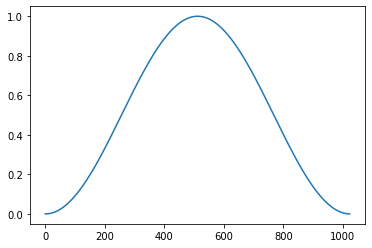

In [168]:
plt.plot(librosa_fft_window)

54 20


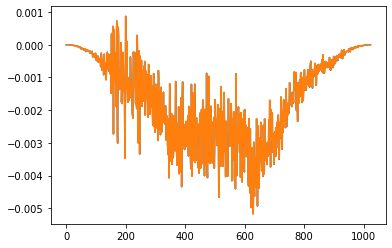

In [162]:
idx = 0
frame = data[idx*config['frame_step']:idx*config['frame_step']+config['n_fft']]
windowed_frame = frame * librosa_fft_window

plt.plot(windowed_frame)
#plt.plot(frame * np.hanning(frame_size))
if dtype == 'int' or dtype=="fix16" or dtype=="fix32_scal":
    plt.plot(gap_windows[idx] * 2.0**(-QWin[idx]))
    print(qsnr(windowed_frame, gap_windows[idx] * 2.0**(-QWin[idx])), QWin[idx])
else:
    plt.plot(gap_windows[idx])
    print(qsnr(windowed_frame, gap_windows[idx]))

47


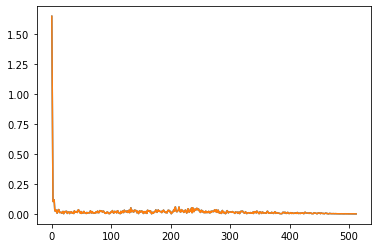

In [163]:
plt.plot(np.abs(stft.T[idx]))
if dtype == 'int' or dtype=="fix16" or dtype=="fix32_scal":
    plt.plot(np.abs(gap_fft[idx])[:n_fft//2+1] * 2.0**(-QFFT[idx]))
    print(qsnr(np.abs(stft.T[idx]), np.abs(gap_fft[idx])[:n_fft//2+1] * 2.0**(-QFFT[idx])))
else:
    plt.plot(np.abs(gap_fft[idx])[:n_fft//2+1])
    print(qsnr(np.abs(stft.T[idx]), np.abs(gap_fft[idx])[:n_fft//2+1]))

46


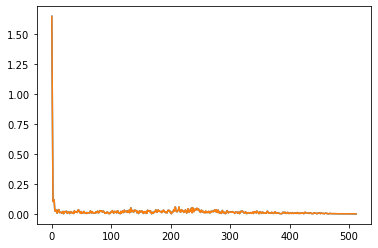

In [164]:
plt.plot(spect.T[idx])
if dtype == 'int' or dtype=="fix16" or dtype=="fix32_scal":
    plt.plot(gap_spect[idx] * 2.0**(-QSPECT[idx]))
    print(qsnr(spect.T[idx], gap_spect[idx] * 2.0**(-QSPECT[idx])))
else:
    plt.plot(gap_spect[idx])
    print(qsnr(spect.T[idx], gap_spect[idx]))    

43


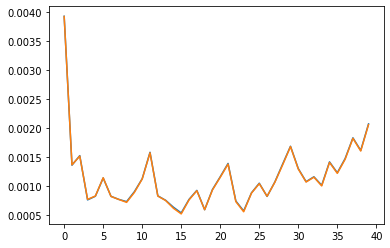

In [165]:
plt.plot(mel_spect.T[idx])
if dtype == "int" or dtype=="fix16" or dtype=="fix32_scal":
    plt.plot(gap_melspect[idx] * 2.0**(-QMEL[idx]))
    print(qsnr(mel_spect.T[idx], gap_melspect[idx] * 2.0**(-QMEL[idx])))
else:
    plt.plot(gap_melspect[idx])
    print(qsnr(mel_spect.T[idx], gap_melspect[idx]))

57


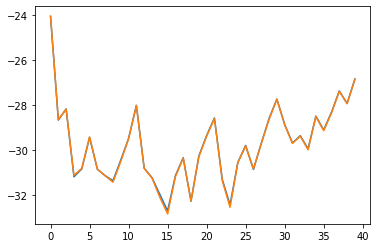

In [166]:
plt.plot(logmel.T[idx])
#plt.plot(power_to_db(mel_spect.T[idx], amin=1e-4))
if dtype == "int" or dtype=="fix16" or dtype=="fix32_scal":
    plt.plot(gap_log[idx] * 2.0**(-QLOG_NORM[idx]))
    print(qsnr(logmel.T[idx], gap_log[idx] * 2.0**(-QLOG_NORM[idx])))
else:
    plt.plot(gap_log[idx])
    print(qsnr(logmel.T[idx], gap_log[idx]))

43
maxdiff: [-0.00709128 -0.01465084  0.00909493  0.03860377  0.00581893  0.0381368
  0.01595782  0.0437807   0.00218719  0.01385958 -0.08440981  0.10212963
  0.00963918  0.03379961  0.01035531  0.00692902  0.04215028 -0.02302769
 -0.02179878  0.00752696 -0.1209354  -0.01219896  0.01223537  0.00321886
 -0.01166543 -0.05655996  0.10701546  0.12857117  0.03488265  0.00686894
  0.01764042 -0.0616458   0.02432222  0.04471287  0.07437198  0.04766781
  0.51536363  0.10792658 -0.11509156 -0.01611201]


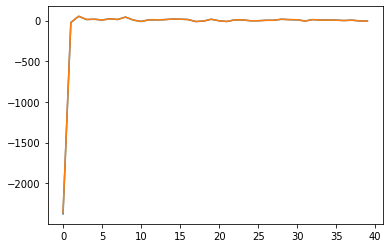

In [167]:
plt.plot(mfcc.T[idx])
if dtype == "int" or dtype=="fix16" or dtype=="fix32_scal":
    plt.plot(gap_dct[idx] * 2.0**(-QDCT[idx]))
    print(qsnr(mfcc.T[idx], gap_dct[idx] * 2.0**(-QDCT[idx])))
    print(f"maxdiff: {np.abs(mfcc.T[idx]- gap_dct[idx] * 2.0**(-QDCT[idx])) / mfcc.T[idx]}")
else:
    plt.plot(gap_dct[idx])
    print(qsnr(mfcc.T[idx], gap_dct[idx]))
#plt.plot(scipy.fftpack.dct(gap_log[idx] * 2.0**(-QLOG_NORM[idx]), axis=0, type=2, norm=None))


In [176]:
MSE = np.sum(np.abs(mfcc.T[:49,:] - gap_dct* 2.0**(-QDCT[idx]))**2)

In [175]:
SUM = np.sum(mfcc.T[:49,:]**2)

In [179]:
10* np.log10(SUM/MSE)

38.68865390184027